<a href="https://colab.research.google.com/github/unmtransinfo/ISBDSCourse/blob/main/python/ISBDS_ML_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>Independent Study in Biomedical Data Science (ISBDS), UNM BIOMED 505</center>

# Tutorial: Supervised machine learning with Python, Pandas, Matplotlib and Scikit-Learn
  * Datasource: [UC Irvine ML Archive](https://archive.ics.uci.edu/)
  * Dataset: [Oxford Parkinson's Disease Detection Dataset](https://archive.ics.uci.edu/ml/datasets/Parkinsons)
  * Algorithms: Naïve Bayes and Neural Networks

In [1]:
import sys,os,re
import urllib.request
import pandas as pd
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.neural_network
from sklearn.cluster import AgglomerativeClustering # hierarchical, Ward's
from scipy.cluster.hierarchy import dendrogram
import matplotlib, matplotlib.pyplot as plt

In [2]:
print(f"Pandas {pd.__version__}; Scikit-learn {sklearn.__version__}; Matplotlib {matplotlib.__version__}")

Pandas 1.3.3; Scikit-learn 0.24.2; Matplotlib 3.4.3


## Function for model performance evaluation:

In [3]:
def print_score(Ytrue, Ypred):
  precision = sklearn.metrics.precision_score(Ytrue, Ypred)
  recall = sklearn.metrics.recall_score(Ytrue, Ypred)
  f1 = sklearn.metrics.f1_score(Ytrue, Ypred)
  print(f"precision: {precision:.2f} ; recall: {recall:.2f} ; F1: {f1:.2f}")

### Plot dendogram function from [Scikit-learn docs](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogramhtml#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

In [4]:
def plot_dendrogram(model, **kwargs):
  # Create linkage matrix and then plot the dendrogram, with counts of samples under each node.
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
      if child_idx < n_samples:
        current_count += 1  # leaf node
      else:
        current_count += counts[child_idx - n_samples]
    counts[i] = current_count
  linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
  dendrogram(linkage_matrix, **kwargs)

## Read dataset: Oxford Parkinson's Disease Detection Dataset

In [5]:
pd_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data", sep=",")

In [6]:
nrows,ncols = pd_df.shape
print(f"dataset ncols: {ncols} ; nrows: {nrows}:")
pd_df.head()

dataset ncols: 24 ; nrows: 195:


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Read metadata


In [7]:
metadata = urllib.request.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.names").read()
print(metadata.decode('utf-8').strip())

Title: Parkinsons Disease Data Set

Abstract: Oxford Parkinson's Disease Detection Dataset

-----------------------------------------------------	

Data Set Characteristics: Multivariate
Number of Instances: 197
Area: Life
Attribute Characteristics: Real
Number of Attributes: 23
Date Donated: 2008-06-26
Associated Tasks: Classification
Missing Values? N/A

-----------------------------------------------------	

Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.

-----------------------------------------------------

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
rec

## Histogram of Jitter(Abs)

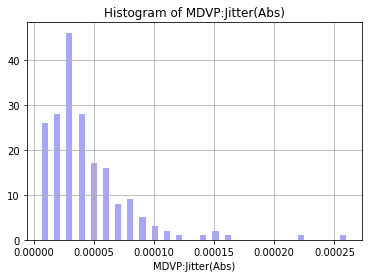

In [8]:
tag = "MDVP:Jitter(Abs)"
n, bins, patches = plt.hist(pd_df[tag], 50, facecolor='#8888FF', alpha=0.75)
plt.xlabel(tag)
plt.title(f'Histogram of {tag}')
plt.grid(True)
plt.show()

## Separate input variables and class labels into X & Y arrays.

In [9]:
Y = pd_df["status"]
datacols = list(set(pd_df.columns) - set(["name", "status"]))
X = pd_df[datacols]

## Cluster using hierarchical Ward's algorithm

Clustering a.k.a. unsupervised learning.

In [10]:
clus = AgglomerativeClustering(compute_full_tree=True, n_clusters=None, distance_threshold=0)
clus.fit(X)
print(f"N: {X.shape[0]}; n_clusters: {clus.n_clusters_}; n_leaves: {clus.n_leaves_}; n_connected_components: {clus.n_connected_components_}")
#clus.distances_

N: 195; n_clusters: 195; n_leaves: 195; n_connected_components: 1


### Plot the top three levels of the dendrogram

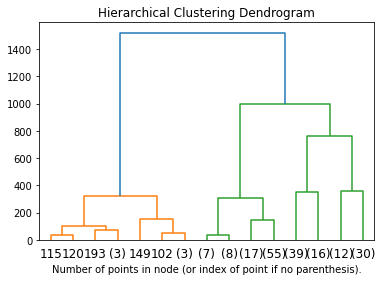

In [11]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clus, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Create train/test split for supervised ML.

In [12]:
Xtrain,Xtest,Ytrain,Ytest = sklearn.model_selection.train_test_split(X, Y, test_size=.25)
print(f"training set: {Xtrain.shape[0]} ; test set: {Xtest.shape[0]}")

training set: 146 ; test set: 49


## Naïve Bayes

In [13]:
nb = sklearn.naive_bayes.GaussianNB() 
nb.fit(Xtrain, Ytrain)
Y_pred = nb.predict(Xtest)
conmat = sklearn.metrics.confusion_matrix(Ytest, Y_pred)
tn, fp, fn, tp = conmat.ravel()
print(f"TP: {tp} ; TN: {tn} ; FP: {fp} ; FN: {fn}")
print_score(Ytest, Y_pred)
pd.DataFrame(conmat, columns=["Predicted_Negative", "Predicted_Postive"], index=["Negative", "Positive"])

TP: 23 ; TN: 16 ; FP: 0 ; FN: 10
precision: 1.00 ; recall: 0.70 ; F1: 0.82


,Predicted_Negative,Predicted_Postive
Negative,16,0
Positive,10,23


## Neural Network

In [14]:
nn = sklearn.neural_network.MLPClassifier() 
nn.fit(Xtrain, Ytrain)
y_pred = nn.predict(Xtest)
conmat = sklearn.metrics.confusion_matrix(Ytest, Y_pred)
tn, fp, fn, tp = conmat.ravel()
print(f"TP: {tp} ; TN: {tn} ; FP: {fp} ; FN: {fn}")
print_score(Ytest, Y_pred)
pd.DataFrame(conmat, columns=["Predicted_Negative", "Predicted_Postive"], index=["Negative", "Positive"])

TP: 23 ; TN: 16 ; FP: 0 ; FN: 10
precision: 1.00 ; recall: 0.70 ; F1: 0.82


,Predicted_Negative,Predicted_Postive
Negative,16,0
Positive,10,23
